In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from time import time
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



# Download necessary NLTK packages
try:
    nltk.download('stopwords')
    nltk.download('punkt_tab')
except Exception as e:
    print(f"Errore durante il download dei pacchetti NLTK: {e}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [26]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [27]:
# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

In [28]:
def preprocess(text):
    tokens = word_tokenize(text)
    return tokens

df['tokens'] = df['Resume_str'].apply(preprocess)

In [29]:
# Training Word2Vec sul campo 'tokens'
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=3, min_count=2)

In [30]:
len(w2v_model.wv.index_to_key)

19857

In [31]:
def get_avg_vector(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

df['vector'] = df['tokens'].apply(lambda x: get_avg_vector(x, w2v_model))

In [32]:
X = np.vstack(df['vector'].values)
y = df['Category']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986, 100)
Validation data size: (497, 100)


In [35]:
def smote(X_train, y_train):
    #print("Distribuzione delle classi nel training set prima di SMOTE:")
    # print(y_train.value_counts())
    
    # Identifica le classi minoritarie
    class_counts = y_train.value_counts()
    min_classes = class_counts[class_counts < 0.7*class_counts.mean()].index.tolist()
    
    if not min_classes:
        print("Nessuna classe minoritaria trovata. SMOTE non applicato.")
        return X_train, y_train

    print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
    
    # Crea un dizionario per la strategia di campionamento
    target_size = int(class_counts.max())
    sampling_strategy = {cls: target_size for cls in min_classes}
    
    # Applica SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # print("Distribuzione delle classi nel training set dopo SMOTE:")
    # print(pd.Series(y_train_resampled).value_counts())
    
    return X_train_resampled, y_train_resampled

In [36]:
X_train_resampled, y_train_resampled = smote(X_train, y_train)

Applicazione di SMOTE alle classi: ['AGRICULTURE', 'AUTOMOBILE', 'BPO'] 



In [37]:
print("Distribuzione delle classi dopo SMOTE:")
print(y_train_resampled.value_counts())

Distribuzione delle classi dopo SMOTE:
Category
AUTOMOBILE                96
BPO                       96
AGRICULTURE               96
INFORMATION-TECHNOLOGY    96
BUSINESS-DEVELOPMENT      95
FITNESS                   94
ENGINEERING               94
ADVOCATE                  94
CHEF                      94
ACCOUNTANT                94
FINANCE                   94
SALES                     93
AVIATION                  93
CONSULTANT                92
BANKING                   92
HEALTHCARE                92
CONSTRUCTION              90
PUBLIC-RELATIONS          89
HR                        88
DESIGNER                  86
ARTS                      82
TEACHER                   82
APPAREL                   78
DIGITAL-MEDIA             77
Name: count, dtype: int64


### Support Vector Classifier

In [38]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [39]:
skf = StratifiedKFold(n_splits=5)

In [40]:
# Pipeline: TF-IDF + Scaling + SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False per sparse matrix
    ('clf', SVC())
])

param_grid_svm = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.1, 1, 10, 100]
    },
    {
        'clf__kernel': ['poly'],
        'clf__C': [1, 10],
        'clf__degree': [2, 3],
        'clf__coef0': [0.5, 1.0]
    }
]

grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=skf,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)


In [41]:
#'''
start = time()
grid_search_svm = grid_svm.fit(X_train_resampled, y_train_resampled)
print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search_svm.cv_results_['params'])} candidates parameter settings.\n")

report(grid_search_svm.cv_results_)
print(grid_search_svm.best_params_)
#'''

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV took 13.03 seconds for 12 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.554 (std: 0.014)
Parameters: {'clf__C': 10, 'clf__coef0': 0.5, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 2
Mean validation score: 0.551 (std: 0.017)
Parameters: {'clf__C': 10, 'clf__coef0': 1.0, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 3
Mean validation score: 0.546 (std: 0.013)
Parameters: {'clf__C': 10, 'clf__coef0': 1.0, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 4
Mean validation score: 0.541 (std: 0.014)
Parameters: {'clf__C': 0.1, 'clf__kernel': 'linear'}

Model with rank: 5
Mean validation score: 0.541 (std: 0.013)
Parameters: {'clf__C': 10, 'clf__coef0': 0.5, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 6
Mean validation score: 0.539 (std: 0.021)
Parameters: {'clf__C': 1, 'clf__kernel': 'linear'}

Model with rank: 7
Mean validation score: 0.

In [42]:
print(grid_search_svm.best_params_)

{'clf__C': 10, 'clf__coef0': 0.5, 'clf__degree': 3, 'clf__kernel': 'poly'}


In [43]:
'''
# Estrai i risultati di GridSearchCV per SVM
results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Filtra i risultati in base ai parametri di interesse (ad esempio, kernel 'linear' vs 'rbf')
filtered_svm = results_svm[
    (results_svm['param_kernel'] == 'rbf')  # o 'linear' a seconda di cosa vuoi visualizzare
]

# Pivot table per visualizzare la "mean_test_score" in funzione di C e gamma
pvt_svm = filtered_svm.pivot_table(
    values='mean_test_score',
    index='param_C',
    columns='param_gamma'
)

# Crea la heatmap
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pvt_svm, cmap='viridis', annot=True, ax=ax)
plt.title('SVM Accuracy (kernel=rbf)')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

'''

'\n# Estrai i risultati di GridSearchCV per SVM\nresults_svm = pd.DataFrame(grid_search_svm.cv_results_)\n\n# Filtra i risultati in base ai parametri di interesse (ad esempio, kernel \'linear\' vs \'rbf\')\nfiltered_svm = results_svm[\n    (results_svm[\'param_kernel\'] == \'rbf\')  # o \'linear\' a seconda di cosa vuoi visualizzare\n]\n\n# Pivot table per visualizzare la "mean_test_score" in funzione di C e gamma\npvt_svm = filtered_svm.pivot_table(\n    values=\'mean_test_score\',\n    index=\'param_C\',\n    columns=\'param_gamma\'\n)\n\n# Crea la heatmap\nf, ax = plt.subplots(figsize=(6, 5))\nsns.heatmap(pvt_svm, cmap=\'viridis\', annot=True, ax=ax)\nplt.title(\'SVM Accuracy (kernel=rbf)\')\nplt.xlabel(\'gamma\')\nplt.ylabel(\'C\')\nplt.show()\n\n'

In [44]:
SVC_Model_best = grid_search_svm.best_estimator_
prediction = SVC_Model_best.predict(X_test)

In [45]:
# SVC_Model_best = SVC(random_state=42, max_features='log2', n_estimators= 700, max_depth=10, criterion='entropy', class_weight='balanced')
# SVC_Model_best.fit(X_train_resampled, y_train_resampled)

In [ ]:
# prediction = SVC_Model_best.predict(X_test)

In [47]:
print("Training Score: {:.2f}".format(SVC_Model_best.score(X_train_resampled, y_train_resampled)))
print("Test Score: {:.2f}".format(SVC_Model_best.score(X_test, y_test)))

Training Score: 0.84
Test Score: 0.53


In [48]:
print(classification_report(y_test, prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.57      0.71      0.63        24
              ADVOCATE       0.36      0.42      0.38        24
           AGRICULTURE       0.28      0.38      0.32        13
               APPAREL       0.23      0.16      0.19        19
                  ARTS       0.27      0.29      0.28        21
            AUTOMOBILE       0.27      0.43      0.33         7
              AVIATION       0.71      0.50      0.59        24
               BANKING       0.72      0.57      0.63        23
                   BPO       0.17      0.25      0.20         4
  BUSINESS-DEVELOPMENT       0.48      0.67      0.56        24
                  CHEF       0.89      0.67      0.76        24
          CONSTRUCTION       0.55      0.50      0.52        22
            CONSULTANT       0.14      0.09      0.11        23
              DESIGNER       0.69      0.52      0.59        21
         DIGITAL-MEDIA       0.60      

<Figure size 1500x1000 with 0 Axes>

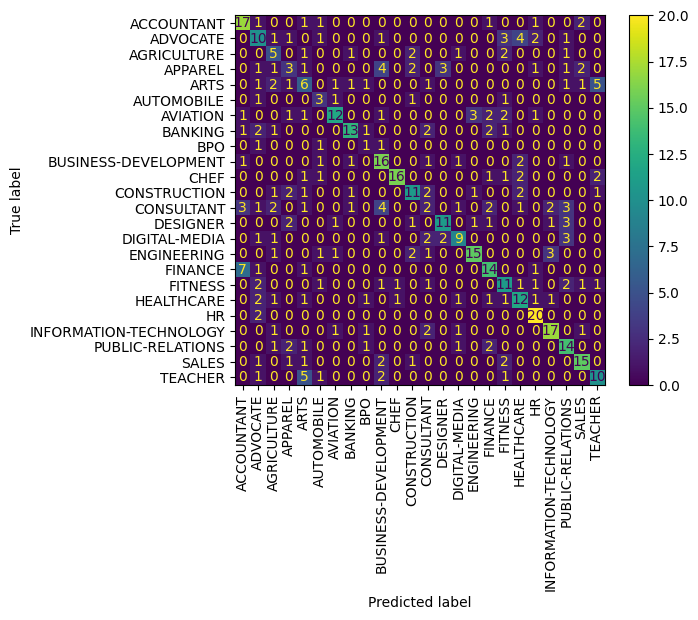

In [49]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

In [50]:
scores = cross_val_score(SVC_Model_best, X_train_resampled, y_train_resampled, cv=skf, scoring='accuracy')
print("Cross-validation scores:", scores)

Cross-validation scores: [0.5412844  0.53899083 0.57701149 0.55402299 0.55632184]
